In [13]:
import os
import sys
import random
import numpy as np
import optuna
import joblib
from importlib import reload  # Import the reload function
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import utils.helpers as hp
import utils.preprocess as pp
import utils.modeling as md  
import utils.tuning as tn
import utils.evaluation as ev

reload(hp)
reload(pp)
reload(md)
reload(tn)
reload(ev)
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
df = hp.fetch_data('ETHUSDT', '15m', '2019-01-01', '2024-12-31')
hp.save_data(df, '../data/ETHUSDT_15m_v200k.csv')

Fetched data from 2019-09-23 08:30:00 to 2019-09-28 17:30:00
Fetched data from 2019-09-28 17:45:00 to 2019-10-03 22:30:00
Fetched data from 2019-10-03 22:45:00 to 2019-10-09 03:30:00
Fetched data from 2019-10-09 03:45:00 to 2019-10-14 08:30:00
Fetched data from 2019-10-14 08:45:00 to 2019-10-19 13:30:00
Fetched data from 2019-10-19 13:45:00 to 2019-10-24 18:30:00
Fetched data from 2019-10-24 18:45:00 to 2019-10-29 23:30:00
Fetched data from 2019-10-29 23:45:00 to 2019-11-04 04:30:00
Fetched data from 2019-11-04 04:45:00 to 2019-11-09 09:30:00
Fetched data from 2019-11-09 09:45:00 to 2019-11-14 14:30:00
Fetched data from 2019-11-14 14:45:00 to 2019-11-19 19:30:00
Fetched data from 2019-11-19 19:45:00 to 2019-11-25 00:30:00
Fetched data from 2019-11-25 00:45:00 to 2019-11-30 05:30:00
Fetched data from 2019-11-30 05:45:00 to 2019-12-05 10:30:00
Fetched data from 2019-12-05 10:45:00 to 2019-12-10 15:30:00
Fetched data from 2019-12-10 15:45:00 to 2019-12-15 20:30:00
Fetched data from 2019-1

In [2]:
timeframe_filenames = {
    "1m": "../data/ETHUSDT_1m_v600k.csv",
    "3m": "../data/ETHUSDT_3m_v600k.csv",
    "5m": "../data/DOGEUSDT_5m_v0.csv",
    "15m": "../data/DOGEUSDT_15m_v0.csv",
    "30m": "../data/DOGEUSDT_30m_v0.csv"
}

In [21]:


params = {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout': 0.5, 'learning_rate': 0.0009559214238176964, 'batch_size': 32, 'dense_units': 16, 'sequence_length': 10, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'num_indicators': 6, 'scaler_type': 'RobustScaler',
'timeframe': '3m', 'window_size': 80, 'look_ahead_size': 20, 'window_shift': 20, 'epochs': 50, "train_size": 3000, "val_size": 500, "step_size": 500, 'shuffle': True}

model_df, test_df = md.load_model_test_split(timeframe_filenames, params)
model = md.custom_model(model_df, params, model_name='ethusdt_3m_v600k_v2')

Dataset loaded from ../data/ETHUSDT_3m_v600k.csv.
Scalers dumped
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.3984 - max_change_loss: 0.1870 - max_change_mae: 0.3237 - min_change_loss: 0.2114 - min_change_mae: 0.3459 - val_loss: 0.0279 - val_max_change_loss: 0.0118 - val_max_change_mae: 0.0625 - val_min_change_loss: 0.0160 - val_min_change_mae: 0.0867
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0468 - max_change_loss: 0.0197 - max_change_mae: 0.1083 - min_change_loss: 0.0270 - min_change_mae: 0.1235 - val_loss: 0.0151 - val_max_change_loss: 0.0035 - val_max_change_mae: 0.0385 - val_min_change_loss: 0.0114 - val_min_change_mae: 0.0521
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0242 - max_change_loss: 0.0102 - max_change_mae: 0.0730 - min_change_loss: 0.0141 - min_change_mae: 0.0865 - val_loss: 0.0088 - val_max_change_loss: 0.0024 - val_max_change_mae: 0.0333 - val_min_change_loss: 0.0062 - val_min_change_mae: 0.0493
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - los

In [22]:
hp.save_model(model, params, model_name='ethusdt_3m_v600k_v2')
norm_X_test, norm_y_test, y_scaler = md.test_data(test_df, params, model_name='ethusdt_3m_v600k_v2')

Model saved to ../models/ethusdt_3m_v600k_v2
Test data dumped


In [23]:
model, params, scaler_X, scaler_y, X_normTest, y_normTest, y_realTest = hp.load_model(model_name='ethusdt_3m_v600k_v1')

Model loaded from ../models/ethusdt_3m_v600k_v1


In [18]:
model.compile(optimizer=params['optimizer'], loss='mean_squared_error', metrics=['mae'])

y_max_test = np.array([y[0] for y in norm_y_test])
y_min_test = np.array([y[1] for y in norm_y_test])
test_loss, test_mae = model.evaluate(X_normTest, [y_max_test, y_min_test], verbose=1)
print(f'Test loss: {test_loss}, Test MAE: {test_mae}')

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 6055
'y' sizes: 6056, 6056


In [24]:

y_pred = model.predict(X_normTest)

y_pred = scaler_y.inverse_transform(y_pred)

rmse_max = np.sqrt(mean_squared_error(y_realTest[:,0], y_pred[:,0]))
rmse_min = np.sqrt(mean_squared_error(y_realTest[:,1], y_pred[:,1]))
rmse_combined = (rmse_min + rmse_max) / 2

print(f'rmse_combined: {rmse_combined}')

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
rmse_combined: 0.004857314345968464


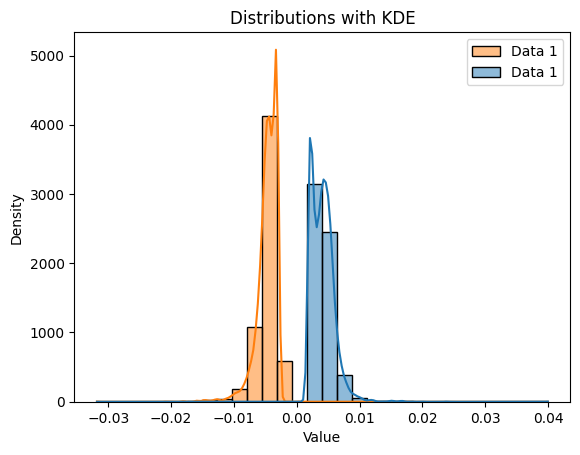

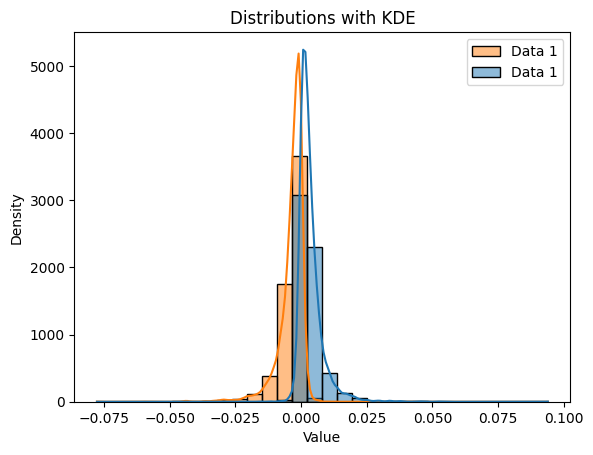

In [25]:

ev.distribution_plot(y_pred)
ev.distribution_plot(y_realTest)


In [30]:
y_pred[:,0].max()

np.float32(0.013737178)

In [35]:
y_realTest[:,0].min()

np.float64(-0.020184077529494113)

In [42]:
ev.calculate_percentage_above_threshold(y_realTest, .02)

np.float64(1.1723910171730516)

In [64]:
ev.profit_simulation(y_pred, y_realTest, 0.011)

np.float64(-0.4312601057110496)

In [20]:
(len(y_realTest) * 20 * 3) / 60 /24

252.33333333333334